In [2]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
import numpy as np
from glob import glob
import seaborn as sns

In [3]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory('chest_xray/test',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical', 
                                            shuffle=False)  # Ensure that it doesn't shuffle the data

Found 624 images belonging to 2 classes.


In [4]:
IMAGE_SIZE = [224, 224]

In [5]:
folders = glob('chest_xray/train/*')
print(folders)

['chest_xray/train\\NORMAL', 'chest_xray/train\\PNEUMONIA']


In [6]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in inception.layers:
    layer.trainable = False
x = Flatten()(inception.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=inception.input, outputs=prediction)

In [7]:
model.load_weights('training_1/inception_pneumonia_weights.h5')

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
test_loss, test_accuracy = model.evaluate(test_set, steps=len(test_set), batch_size=8)

20/20 [==============================] - 13s 228ms/step - loss: 1.0940 - accuracy: 0.8526


In [10]:
predictions = model.predict(test_set, steps=len(test_set))

20/20 [==============================] - 4s 157ms/step


In [11]:
true_labels = test_set.classes

In [12]:
predicted_labels = np.argmax(predictions, axis=1)

In [13]:
report = classification_report(true_labels, predicted_labels, target_names=test_set.class_indices.keys())
confusion = confusion_matrix(true_labels, predicted_labels)

# Print the test accuracy and other metrics
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print('\nClassification Report:\n', report)
print('\nConfusion Matrix:\n', confusion)

Test Loss: 1.0940
Test Accuracy: 0.8526

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.81      0.79      0.80       234
   PNEUMONIA       0.88      0.89      0.88       390

    accuracy                           0.85       624
   macro avg       0.84      0.84      0.84       624
weighted avg       0.85      0.85      0.85       624


Confusion Matrix:
 [[185  49]
 [ 43 347]]


In [14]:
fpr, tpr, _ = roc_curve(true_labels, predictions[:, 1])  # Assuming pneumonia is the positive class
roc_auc = auc(fpr, tpr)

c:\Users\Biki\anaconda3\envs\venv1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Biki\anaconda3\envs\venv1\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


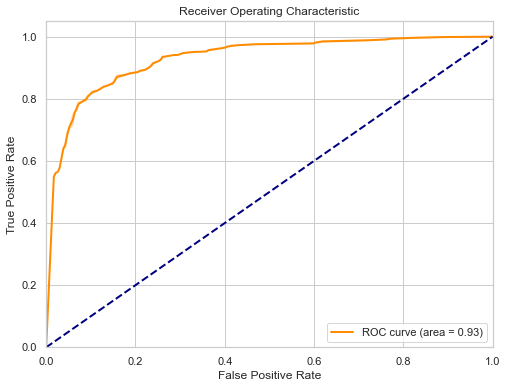

In [15]:
sns.set(style="whitegrid")

# Create ROC curve plot
plt.figure(figsize=(8, 6))
sns.lineplot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
sns.lineplot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Show the plot
plt.show()